In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, PReLU
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import mean_absolute_percentage_error

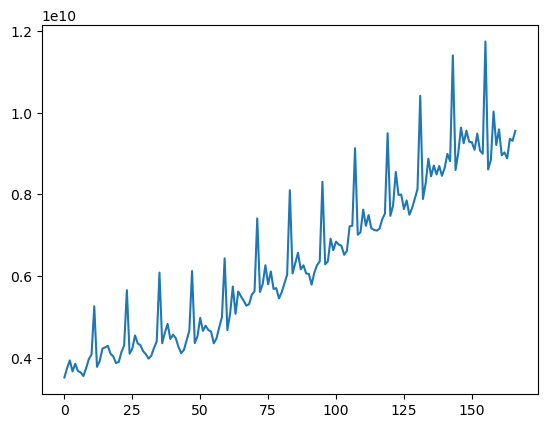

In [2]:
# numpyを使う
# ここでは元系列のまま分析を行う
series = np.loadtxt("../public/seijyo_ishii_monthly_sales_without_header.csv")
plt.plot(series)
plt.show()

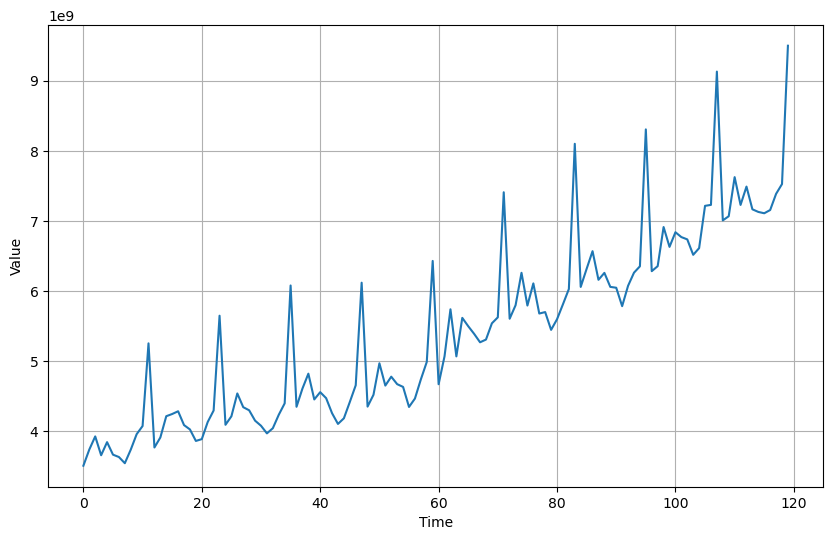

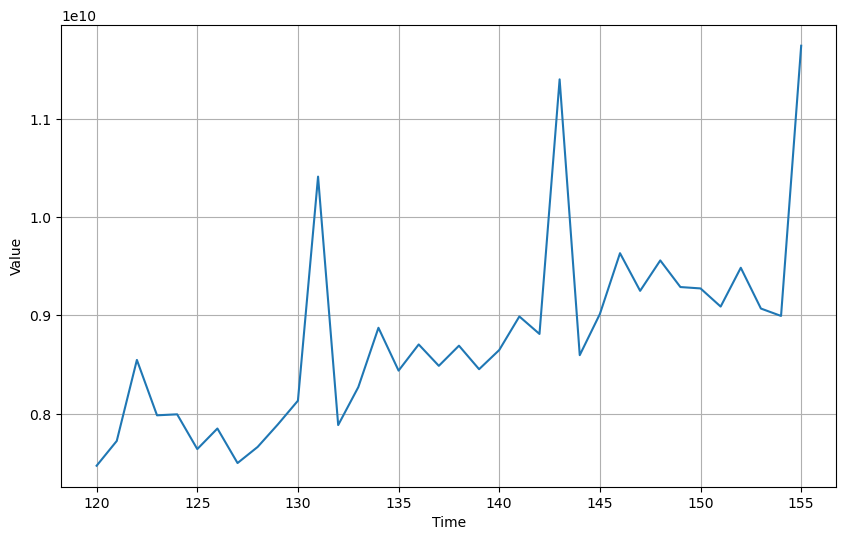

In [3]:
# 前半120時点を学習データ、以降を検証データとして分割

split_time = 120
time = np.arange(156, dtype="float32")    # 2022年12月のデータが取得できれば、168に変更

time_train = time[:split_time]
x_train = series[:split_time]
time_train_pred = time[20:split_time]
time_valid = time[split_time:156]
x_valid = series[split_time:156]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train) # 学習セット
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 検証セット
plt.show()

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
return dataset

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
4/4 [==============================] - 1s 12ms/step - loss: 115.5145
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 113.3810
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 110.9855
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 108.5748
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 106.4506
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 104.8942
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 103.7630
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 102.7771
Epoch 9/100
4/4 [==============================] - 0s 28ms/step - loss: 101.8310
Epoch 10/100
4/4 [==============================] - 0s 10ms/step - loss: 100.8907
Epoch 11/100
4/4 [==============================] - 0s 8ms/step - loss: 99.9558
Epoch 12/100
4/4 [==============================] - 0s 3ms/step - loss: 99.0829
Epoch 13/100
4/4 [==================

1/1 [==============================] - 0s 16ms/step


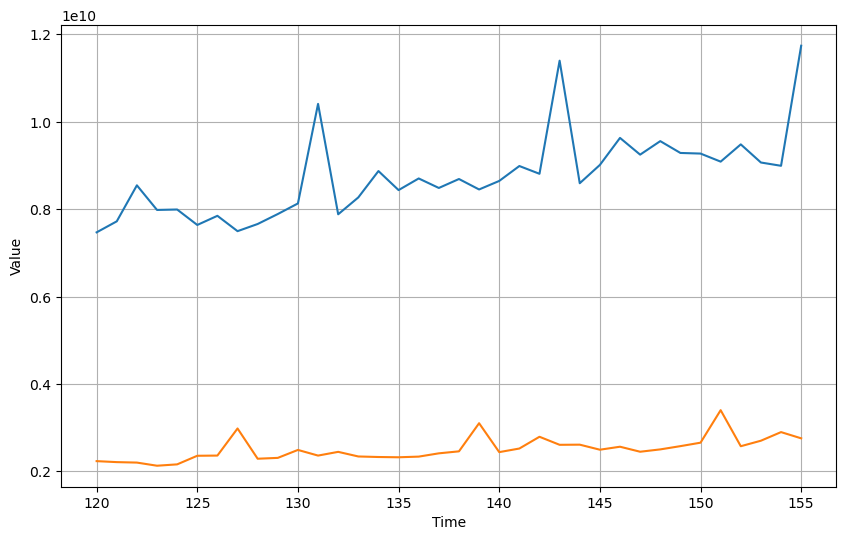

In [13]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [14]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.7114459431762445


In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 10ms/step - loss: 82.9329
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 81.1105
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 78.9464
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 76.7298
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 74.5003
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 72.2911
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 70.0749
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 67.8200
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 65.5137
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 63.1824
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 60.7489
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 58.3086
Epoch 13/500
4/4 [==============================] - 0s 3ms/s

4/4 [==============================] - 0s 8ms/step - loss: 25.4772
Epoch 205/500
4/4 [==============================] - 0s 5ms/step - loss: 25.4213
Epoch 206/500
4/4 [==============================] - 0s 4ms/step - loss: 25.1402
Epoch 207/500
4/4 [==============================] - 0s 5ms/step - loss: 24.7172
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 25.3769
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 25.3612
Epoch 210/500
4/4 [==============================] - 0s 5ms/step - loss: 25.3718
Epoch 211/500
4/4 [==============================] - 0s 5ms/step - loss: 25.2021
Epoch 212/500
4/4 [==============================] - 0s 5ms/step - loss: 25.3103
Epoch 213/500
4/4 [==============================] - 0s 5ms/step - loss: 25.5843
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 25.0335
Epoch 215/500
4/4 [==============================] - 0s 4ms/step - loss: 25.1603
Epoch 216/500
4/4 [=======================

4/4 [==============================] - 0s 4ms/step - loss: 24.4568
Epoch 407/500
4/4 [==============================] - 0s 3ms/step - loss: 24.2155
Epoch 408/500
4/4 [==============================] - 0s 4ms/step - loss: 23.7700
Epoch 409/500
4/4 [==============================] - 0s 4ms/step - loss: 24.5848
Epoch 410/500
4/4 [==============================] - 0s 3ms/step - loss: 24.5050
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 24.6711
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 24.0136
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 24.5122
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 24.5492
Epoch 415/500
4/4 [==============================] - 0s 5ms/step - loss: 23.8088
Epoch 416/500
4/4 [==============================] - 0s 4ms/step - loss: 24.6862
Epoch 417/500
4/4 [==============================] - 0s 4ms/step - loss: 24.6369
Epoch 418/500
4/4 [=======================

1/1 [==============================] - 0s 21ms/step


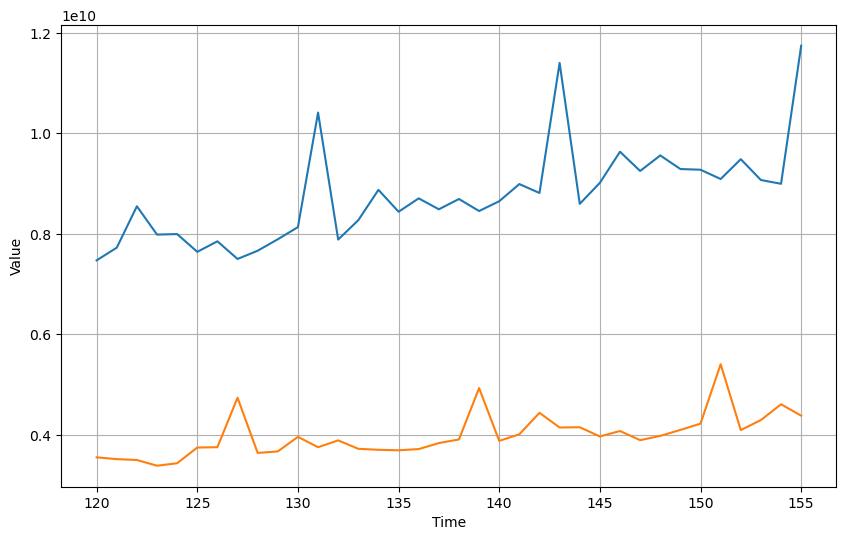

In [16]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset, epochs=5000,  verbose=1)

Epoch 1/5000
4/4 [==============================] - 1s 36ms/step - loss: 104.6044
Epoch 2/5000
4/4 [==============================] - 0s 5ms/step - loss: 104.4454
Epoch 3/5000
4/4 [==============================] - 0s 6ms/step - loss: 104.2787
Epoch 4/5000
4/4 [==============================] - 0s 3ms/step - loss: 104.1016
Epoch 5/5000
4/4 [==============================] - 0s 4ms/step - loss: 103.9450
Epoch 6/5000
4/4 [==============================] - 0s 5ms/step - loss: 103.7863
Epoch 7/5000
4/4 [==============================] - 0s 4ms/step - loss: 103.6310
Epoch 8/5000
4/4 [==============================] - 0s 5ms/step - loss: 103.4648
Epoch 9/5000
4/4 [==============================] - 0s 4ms/step - loss: 103.3127
Epoch 10/5000
4/4 [==============================] - 0s 4ms/step - loss: 103.1658
Epoch 11/5000
4/4 [==============================] - 0s 5ms/step - loss: 103.0083
Epoch 12/5000
4/4 [==============================] - 0s 4ms/step - loss: 102.8638
Epoch 13/5000
4/4 [=====

4/4 [==============================] - 0s 3ms/step - loss: 71.1201
Epoch 202/5000
4/4 [==============================] - 0s 4ms/step - loss: 70.2755
Epoch 203/5000
4/4 [==============================] - 0s 4ms/step - loss: 69.4090
Epoch 204/5000
4/4 [==============================] - 0s 3ms/step - loss: 68.5606
Epoch 205/5000
4/4 [==============================] - 0s 3ms/step - loss: 67.5690
Epoch 206/5000
4/4 [==============================] - 0s 4ms/step - loss: 66.6237
Epoch 207/5000
4/4 [==============================] - 0s 4ms/step - loss: 65.7072
Epoch 208/5000
4/4 [==============================] - 0s 4ms/step - loss: 64.5950
Epoch 209/5000
4/4 [==============================] - 0s 4ms/step - loss: 63.5116
Epoch 210/5000
4/4 [==============================] - 0s 4ms/step - loss: 62.4323
Epoch 211/5000
4/4 [==============================] - 0s 4ms/step - loss: 61.2260
Epoch 212/5000
4/4 [==============================] - 0s 4ms/step - loss: 60.1294
Epoch 213/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 25.5025
Epoch 302/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.8726
Epoch 303/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.2088
Epoch 304/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.9047
Epoch 305/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.6964
Epoch 306/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.8138
Epoch 307/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.7194
Epoch 308/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.7716
Epoch 309/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.5385
Epoch 310/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.5708
Epoch 311/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.5240
Epoch 312/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.6870
Epoch 313/5000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 25.7470
Epoch 402/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.6419
Epoch 403/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.4348
Epoch 404/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.3718
Epoch 405/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.7907
Epoch 406/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.5938
Epoch 407/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.4590
Epoch 408/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.2794
Epoch 409/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.0981
Epoch 410/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.5300
Epoch 411/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.3121
Epoch 412/5000
4/4 [==============================] - 0s 5ms/step - loss: 25.3464
Epoch 413/5000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 25.4501
Epoch 502/5000
4/4 [==============================] - 0s 5ms/step - loss: 25.4368
Epoch 503/5000
4/4 [==============================] - 0s 5ms/step - loss: 25.3137
Epoch 504/5000
4/4 [==============================] - 0s 5ms/step - loss: 25.1556
Epoch 505/5000
4/4 [==============================] - 0s 5ms/step - loss: 25.1004
Epoch 506/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.8777
Epoch 507/5000
4/4 [==============================] - 0s 5ms/step - loss: 25.1358
Epoch 508/5000
4/4 [==============================] - 0s 5ms/step - loss: 25.1804
Epoch 509/5000
4/4 [==============================] - 0s 5ms/step - loss: 25.5163
Epoch 510/5000
4/4 [==============================] - 0s 5ms/step - loss: 25.4299
Epoch 511/5000
4/4 [==============================] - 0s 5ms/step - loss: 25.4583
Epoch 512/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.3273
Epoch 513/5000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 24.9629
Epoch 602/5000
4/4 [==============================] - 0s 6ms/step - loss: 24.9738
Epoch 603/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.2789
Epoch 604/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.2911
Epoch 605/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.7589
Epoch 606/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.0405
Epoch 607/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.6388
Epoch 608/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.1754
Epoch 609/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.0625
Epoch 610/5000
4/4 [==============================] - 0s 4ms/step - loss: 25.1371
Epoch 611/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.9288
Epoch 612/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.1110
Epoch 613/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 24.6286
Epoch 702/5000
4/4 [==============================] - 0s 3ms/step - loss: 25.0925
Epoch 703/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.5397
Epoch 704/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.8949
Epoch 705/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.8187
Epoch 706/5000
4/4 [==============================] - 0s 6ms/step - loss: 24.6554
Epoch 707/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.7756
Epoch 708/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.8713
Epoch 709/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.7971
Epoch 710/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.8564
Epoch 711/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.5004
Epoch 712/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.4599
Epoch 713/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 24.8203
Epoch 802/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.7314
Epoch 803/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.5424
Epoch 804/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.4797
Epoch 805/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.9316
Epoch 806/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.3922
Epoch 807/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.4041
Epoch 808/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.2490
Epoch 809/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.4892
Epoch 810/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.5480
Epoch 811/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.5729
Epoch 812/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.2380
Epoch 813/5000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 24.5163
Epoch 902/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.5751
Epoch 903/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.5940
Epoch 904/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.5912
Epoch 905/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.4803
Epoch 906/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.1105
Epoch 907/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.3812
Epoch 908/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.5500
Epoch 909/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.6332
Epoch 910/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.2769
Epoch 911/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.5477
Epoch 912/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.7549
Epoch 913/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 24.6250
Epoch 1002/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.4049
Epoch 1003/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.5002
Epoch 1004/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.8089
Epoch 1005/5000
4/4 [==============================] - 0s 6ms/step - loss: 24.4648
Epoch 1006/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.5113
Epoch 1007/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.0997
Epoch 1008/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.1716
Epoch 1009/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.9648
Epoch 1010/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.1099
Epoch 1011/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.4753
Epoch 1012/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.2373
Epoch 1013/5000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 24.1895
Epoch 1198/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.8677
Epoch 1199/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.0845
Epoch 1200/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.3538
Epoch 1201/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.1705
Epoch 1202/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9044
Epoch 1203/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.2060
Epoch 1204/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.2760
Epoch 1205/5000
4/4 [==============================] - 0s 3ms/step - loss: 24.1380
Epoch 1206/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.1044
Epoch 1207/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.1872
Epoch 1208/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.8422
Epoch 1209/5000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 23.5073
Epoch 1394/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.5784
Epoch 1395/5000
4/4 [==============================] - 0s 4ms/step - loss: 24.0519
Epoch 1396/5000
4/4 [==============================] - 0s 5ms/step - loss: 24.1405
Epoch 1397/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.9532
Epoch 1398/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.7634
Epoch 1399/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.7415
Epoch 1400/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.4510
Epoch 1401/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.2531
Epoch 1402/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.6176
Epoch 1403/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.0861
Epoch 1404/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.9748
Epoch 1405/5000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 23.8670
Epoch 1590/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.7219
Epoch 1591/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0725
Epoch 1592/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.2110
Epoch 1593/5000
4/4 [==============================] - 0s 6ms/step - loss: 23.4294
Epoch 1594/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.6522
Epoch 1595/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.5337
Epoch 1596/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.4807
Epoch 1597/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.2108
Epoch 1598/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.8998
Epoch 1599/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.4044
Epoch 1600/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.3354
Epoch 1601/5000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 23.3455
Epoch 1786/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.3188
Epoch 1787/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.3862
Epoch 1788/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.3404
Epoch 1789/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.1540
Epoch 1790/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.3730
Epoch 1791/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.2257
Epoch 1792/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.6180
Epoch 1793/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.4822
Epoch 1794/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.4108
Epoch 1795/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.5662
Epoch 1796/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.9173
Epoch 1797/5000
4/4 

4/4 [==============================] - 0s 5ms/step - loss: 23.2219
Epoch 1982/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.4459
Epoch 1983/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9350
Epoch 1984/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.3771
Epoch 1985/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.1322
Epoch 1986/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9346
Epoch 1987/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.3689
Epoch 1988/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0327
Epoch 1989/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.3849
Epoch 1990/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.1185
Epoch 1991/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.3664
Epoch 1992/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.5223
Epoch 1993/5000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 23.3113
Epoch 2178/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.2331
Epoch 2179/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.2486
Epoch 2180/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.7119
Epoch 2181/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.0960
Epoch 2182/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.3238
Epoch 2183/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0780
Epoch 2184/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.2696
Epoch 2185/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.3746
Epoch 2186/5000
4/4 [==============================] - 0s 7ms/step - loss: 23.4791
Epoch 2187/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.2326
Epoch 2188/5000
4/4 [==============================] - 0s 6ms/step - loss: 23.3964
Epoch 2189/5000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 22.8416
Epoch 2374/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.1239
Epoch 2375/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.3118
Epoch 2376/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0795
Epoch 2377/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.7371
Epoch 2378/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.8721
Epoch 2379/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.2046
Epoch 2380/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.2374
Epoch 2381/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.6890
Epoch 2382/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.2517
Epoch 2383/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.9297
Epoch 2384/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8125
Epoch 2385/5000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 23.0665
Epoch 2570/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.1781
Epoch 2571/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.2562
Epoch 2572/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0996
Epoch 2573/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.3743
Epoch 2574/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9015
Epoch 2575/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.3018
Epoch 2576/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8609
Epoch 2577/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9784
Epoch 2578/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.1007
Epoch 2579/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.1965
Epoch 2580/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.0339
Epoch 2581/5000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 23.2542
Epoch 2766/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.6989
Epoch 2767/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.2950
Epoch 2768/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.2194
Epoch 2769/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.9763
Epoch 2770/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0873
Epoch 2771/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.3784
Epoch 2772/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.7931
Epoch 2773/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.1214
Epoch 2774/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8769
Epoch 2775/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8857
Epoch 2776/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0805
Epoch 2777/5000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 22.9159
Epoch 2962/5000
4/4 [==============================] - 0s 6ms/step - loss: 22.8467
Epoch 2963/5000
4/4 [==============================] - 0s 6ms/step - loss: 22.8270
Epoch 2964/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.0684
Epoch 2965/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.0177
Epoch 2966/5000
4/4 [==============================] - 0s 8ms/step - loss: 23.0753
Epoch 2967/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.0405
Epoch 2968/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.9157
Epoch 2969/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.4582
Epoch 2970/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.0867
Epoch 2971/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.8202
Epoch 2972/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.8442
Epoch 2973/5000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 22.7226
Epoch 3158/5000
4/4 [==============================] - 0s 3ms/step - loss: 21.8803
Epoch 3159/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.6765
Epoch 3160/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.7971
Epoch 3161/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0749
Epoch 3162/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0228
Epoch 3163/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9222
Epoch 3164/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0510
Epoch 3165/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0476
Epoch 3166/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0722
Epoch 3167/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.3318
Epoch 3168/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.8570
Epoch 3169/5000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 22.8397
Epoch 3354/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.5992
Epoch 3355/5000
4/4 [==============================] - 0s 6ms/step - loss: 22.5330
Epoch 3356/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.5964
Epoch 3357/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.9236
Epoch 3358/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8830
Epoch 3359/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9239
Epoch 3360/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9007
Epoch 3361/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.5599
Epoch 3362/5000
4/4 [==============================] - 0s 6ms/step - loss: 22.1446
Epoch 3363/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.9835
Epoch 3364/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.5093
Epoch 3365/5000
4/4 

4/4 [==============================] - 0s 3ms/step - loss: 22.8789
Epoch 3550/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.7545
Epoch 3551/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.2974
Epoch 3552/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0182
Epoch 3553/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.5236
Epoch 3554/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.2357
Epoch 3555/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.5378
Epoch 3556/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.5498
Epoch 3557/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9839
Epoch 3558/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.1766
Epoch 3559/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0385
Epoch 3560/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.6759
Epoch 3561/5000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 23.0127
Epoch 3746/5000
4/4 [==============================] - 0s 4ms/step - loss: 21.8934
Epoch 3747/5000
4/4 [==============================] - 0s 4ms/step - loss: 21.8976
Epoch 3748/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.8992
Epoch 3749/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.1418
Epoch 3750/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.7492
Epoch 3751/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8732
Epoch 3752/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.8764
Epoch 3753/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.7181
Epoch 3754/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0177
Epoch 3755/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.7998
Epoch 3756/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.6910
Epoch 3757/5000
4/4 

4/4 [==============================] - 0s 6ms/step - loss: 22.9813
Epoch 3942/5000
4/4 [==============================] - 0s 5ms/step - loss: 21.4656
Epoch 3943/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.7051
Epoch 3944/5000
4/4 [==============================] - 0s 6ms/step - loss: 22.9704
Epoch 3945/5000
4/4 [==============================] - 0s 6ms/step - loss: 22.7968
Epoch 3946/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.3488
Epoch 3947/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9568
Epoch 3948/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8596
Epoch 3949/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8439
Epoch 3950/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9110
Epoch 3951/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.3584
Epoch 3952/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.9479
Epoch 3953/5000
4/4 

4/4 [==============================] - 0s 8ms/step - loss: 23.0706
Epoch 4138/5000
4/4 [==============================] - 0s 5ms/step - loss: 23.0236
Epoch 4139/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.3431
Epoch 4140/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.6204
Epoch 4141/5000
4/4 [==============================] - 0s 3ms/step - loss: 23.0038
Epoch 4142/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.9548
Epoch 4143/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9306
Epoch 4144/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.6021
Epoch 4145/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.6796
Epoch 4146/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8622
Epoch 4147/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.5925
Epoch 4148/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.8459
Epoch 4149/5000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 22.8481
Epoch 4334/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.3379
Epoch 4335/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9637
Epoch 4336/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.7814
Epoch 4337/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.5546
Epoch 4338/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8529
Epoch 4339/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.0334
Epoch 4340/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.6240
Epoch 4341/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8791
Epoch 4342/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.7530
Epoch 4343/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.2265
Epoch 4344/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.7452
Epoch 4345/5000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 22.8773
Epoch 4530/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9555
Epoch 4531/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.8630
Epoch 4532/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.6158
Epoch 4533/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.9963
Epoch 4534/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.9926
Epoch 4535/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.4983
Epoch 4536/5000
4/4 [==============================] - 0s 9ms/step - loss: 22.7541
Epoch 4537/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.3170
Epoch 4538/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.2619
Epoch 4539/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.5837
Epoch 4540/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.5874
Epoch 4541/5000
4/4 

4/4 [==============================] - 0s 5ms/step - loss: 22.0471
Epoch 4726/5000
4/4 [==============================] - 0s 7ms/step - loss: 22.7443
Epoch 4727/5000
4/4 [==============================] - 0s 6ms/step - loss: 23.0424
Epoch 4728/5000
4/4 [==============================] - 0s 6ms/step - loss: 22.6088
Epoch 4729/5000
4/4 [==============================] - 0s 6ms/step - loss: 22.8190
Epoch 4730/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.9961
Epoch 4731/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.6915
Epoch 4732/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.2768
Epoch 4733/5000
4/4 [==============================] - 0s 3ms/step - loss: 22.6541
Epoch 4734/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.3673
Epoch 4735/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.7417
Epoch 4736/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.8800
Epoch 4737/5000
4/4 

4/4 [==============================] - 0s 4ms/step - loss: 22.3222
Epoch 4922/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.5515
Epoch 4923/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.0035
Epoch 4924/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.9980
Epoch 4925/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.4047
Epoch 4926/5000
4/4 [==============================] - 0s 5ms/step - loss: 22.9193
Epoch 4927/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.4371
Epoch 4928/5000
4/4 [==============================] - 0s 4ms/step - loss: 23.0205
Epoch 4929/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.4187
Epoch 4930/5000
4/4 [==============================] - 0s 4ms/step - loss: 22.6430
Epoch 4931/5000
4/4 [==============================] - 0s 22ms/step - loss: 22.3338
Epoch 4932/5000
4/4 [==============================] - 0s 6ms/step - loss: 22.8408
Epoch 4933/5000
4/4

1/1 [==============================] - 0s 19ms/step


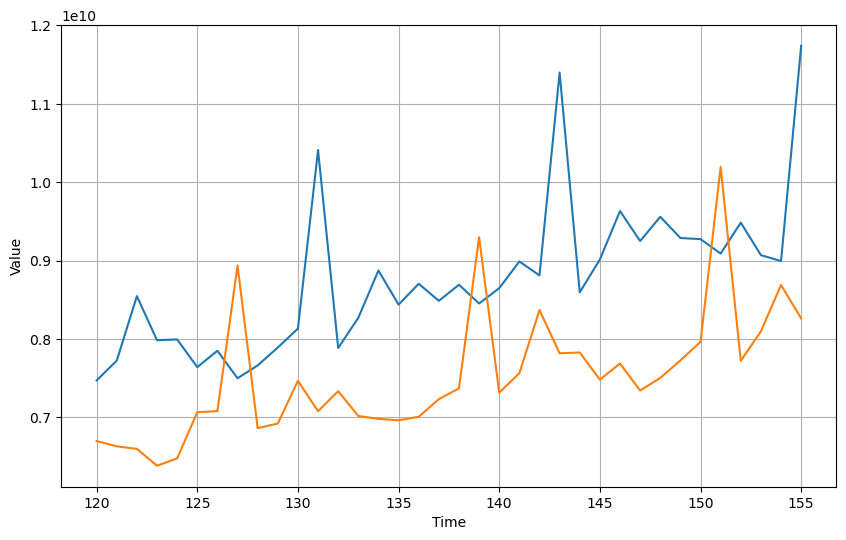

In [18]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [19]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.15777957484103725


In [20]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 44ms/step - loss: 102.1589
Epoch 2/500
4/4 [==============================] - 0s 4ms/step - loss: 101.1047
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 100.5689
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 100.4840
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 100.4498
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 100.4219
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 100.3963
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 100.3742
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 100.3592
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 100.3502
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 100.3438
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 100.3377
Epoch 13/500
4/4 [==============================

4/4 [==============================] - 0s 4ms/step - loss: 99.3227
Epoch 204/500
4/4 [==============================] - 0s 3ms/step - loss: 99.3150
Epoch 205/500
4/4 [==============================] - 0s 3ms/step - loss: 99.3056
Epoch 206/500
4/4 [==============================] - 0s 3ms/step - loss: 99.2973
Epoch 207/500
4/4 [==============================] - 0s 4ms/step - loss: 99.2900
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 99.2803
Epoch 209/500
4/4 [==============================] - 0s 3ms/step - loss: 99.2727
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 99.2634
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 99.2546
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 99.2463
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 99.2385
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 99.2295
Epoch 215/500
4/4 [=======================

4/4 [==============================] - 0s 5ms/step - loss: 89.7988
Epoch 406/500
4/4 [==============================] - 0s 5ms/step - loss: 89.6136
Epoch 407/500
4/4 [==============================] - 0s 4ms/step - loss: 89.3936
Epoch 408/500
4/4 [==============================] - 0s 4ms/step - loss: 89.1719
Epoch 409/500
4/4 [==============================] - 0s 3ms/step - loss: 88.9607
Epoch 410/500
4/4 [==============================] - 0s 5ms/step - loss: 88.7340
Epoch 411/500
4/4 [==============================] - 0s 5ms/step - loss: 88.4985
Epoch 412/500
4/4 [==============================] - 0s 4ms/step - loss: 88.2693
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 88.0192
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 87.7817
Epoch 415/500
4/4 [==============================] - 0s 5ms/step - loss: 87.5588
Epoch 416/500
4/4 [==============================] - 0s 4ms/step - loss: 87.2488
Epoch 417/500
4/4 [=======================

1/1 [==============================] - 0s 20ms/step


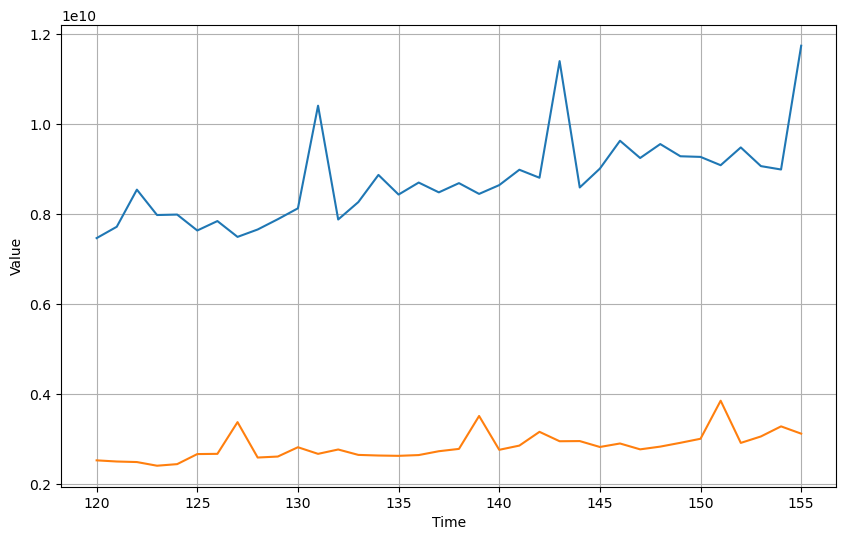

In [21]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [22]:
%%time
# 学習率の大まかなエリアを絞り込む
# ReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=0)

CPU times: user 25 s, sys: 3.33 s, total: 28.4 s
Wall time: 22.6 s


(1e-08, 0.001, 0.0, 300.0)

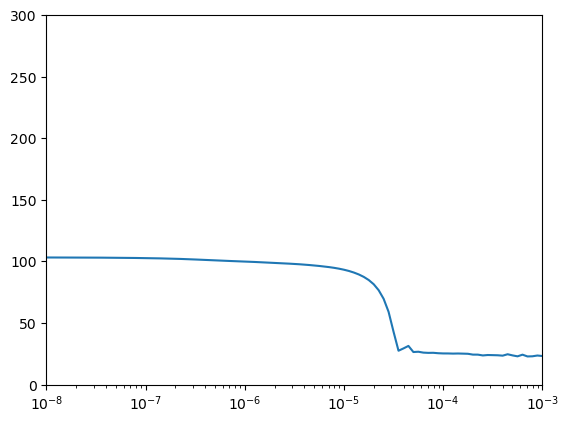

In [23]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [24]:
%%time
# 学習率の大まかなエリアを絞り込む
# ReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(20, activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"), 
    tf.keras.layers.Dense(1),
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=0)

CPU times: user 26.1 s, sys: 3.31 s, total: 29.4 s
Wall time: 18.9 s


(1e-08, 0.001, 0.0, 300.0)

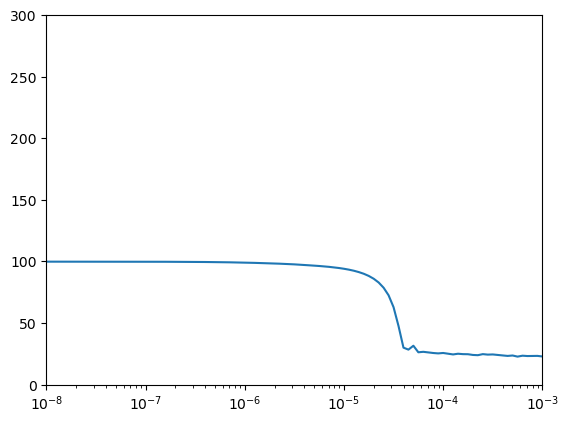

In [25]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [26]:
# 畳み込みでは学習率10^-4くらいがいい

In [27]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=1.0))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 12ms/step - loss: 100.9147
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 97.1197
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 84.8234
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 49.5430
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 60.8358
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 65.9251
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 47.4540
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 82.9616
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 80.0587
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 55.1235
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 33.5182
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 58.3521
Epoch 13/500
4/4 [=============================

4/4 [==============================] - 0s 7ms/step - loss: 23.8730
Epoch 205/500
4/4 [==============================] - 0s 6ms/step - loss: 24.8986
Epoch 206/500
4/4 [==============================] - 0s 6ms/step - loss: 24.4028
Epoch 207/500
4/4 [==============================] - 0s 5ms/step - loss: 25.4391
Epoch 208/500
4/4 [==============================] - 0s 6ms/step - loss: 23.5551
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 26.7106
Epoch 210/500
4/4 [==============================] - 0s 6ms/step - loss: 23.7383
Epoch 211/500
4/4 [==============================] - 0s 5ms/step - loss: 27.4705
Epoch 212/500
4/4 [==============================] - 0s 5ms/step - loss: 23.9581
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 25.2694
Epoch 214/500
4/4 [==============================] - 0s 4ms/step - loss: 26.9409
Epoch 215/500
4/4 [==============================] - 0s 4ms/step - loss: 28.2931
Epoch 216/500
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 27.5020
Epoch 407/500
4/4 [==============================] - 0s 4ms/step - loss: 24.6029
Epoch 408/500
4/4 [==============================] - 0s 4ms/step - loss: 28.0914
Epoch 409/500
4/4 [==============================] - 0s 5ms/step - loss: 26.0489
Epoch 410/500
4/4 [==============================] - 0s 7ms/step - loss: 26.3516
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 31.9212
Epoch 412/500
4/4 [==============================] - 0s 4ms/step - loss: 25.1527
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 33.5468
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 26.5097
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 29.8382
Epoch 416/500
4/4 [==============================] - 0s 4ms/step - loss: 30.4997
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 27.7406
Epoch 418/500
4/4 [=======================

1/1 [==============================] - 0s 18ms/step


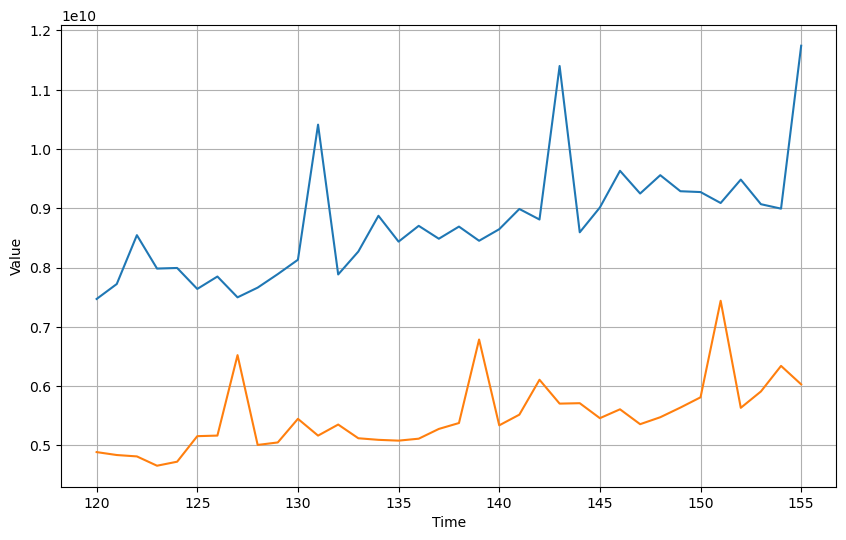

In [28]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [29]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=512, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(1),
])


model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=1.0))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 10ms/step - loss: 94.8989
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 87.2333
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 60.1349
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 36.6586
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 70.6695
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 30.8840
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 67.8205
Epoch 8/500
4/4 [==============================] - 0s 6ms/step - loss: 72.5387
Epoch 9/500
4/4 [==============================] - 0s 6ms/step - loss: 50.4314
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 39.0276
Epoch 11/500
4/4 [==============================] - 0s 6ms/step - loss: 62.5938
Epoch 12/500
4/4 [==============================] - 0s 6ms/step - loss: 32.7404
Epoch 13/500
4/4 [==============================

4/4 [==============================] - 0s 8ms/step - loss: 30.3532
Epoch 205/500
4/4 [==============================] - 0s 5ms/step - loss: 31.5821
Epoch 206/500
4/4 [==============================] - 0s 5ms/step - loss: 33.7805
Epoch 207/500
4/4 [==============================] - 0s 5ms/step - loss: 30.5306
Epoch 208/500
4/4 [==============================] - 0s 5ms/step - loss: 46.1333
Epoch 209/500
4/4 [==============================] - 0s 5ms/step - loss: 30.2042
Epoch 210/500
4/4 [==============================] - 0s 7ms/step - loss: 40.8379
Epoch 211/500
4/4 [==============================] - 0s 8ms/step - loss: 39.5338
Epoch 212/500
4/4 [==============================] - 0s 5ms/step - loss: 31.6280
Epoch 213/500
4/4 [==============================] - 0s 6ms/step - loss: 49.5813
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 37.5942
Epoch 215/500
4/4 [==============================] - 0s 7ms/step - loss: 30.3192
Epoch 216/500
4/4 [=======================

4/4 [==============================] - 0s 5ms/step - loss: 25.2658
Epoch 407/500
4/4 [==============================] - 0s 6ms/step - loss: 26.5088
Epoch 408/500
4/4 [==============================] - 0s 5ms/step - loss: 24.4856
Epoch 409/500
4/4 [==============================] - 0s 5ms/step - loss: 24.0916
Epoch 410/500
4/4 [==============================] - 0s 4ms/step - loss: 24.1639
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 23.9750
Epoch 412/500
4/4 [==============================] - 0s 6ms/step - loss: 23.6278
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 24.8655
Epoch 414/500
4/4 [==============================] - 0s 5ms/step - loss: 26.0943
Epoch 415/500
4/4 [==============================] - 0s 5ms/step - loss: 25.3736
Epoch 416/500
4/4 [==============================] - 0s 5ms/step - loss: 24.5412
Epoch 417/500
4/4 [==============================] - 0s 4ms/step - loss: 25.7198
Epoch 418/500
4/4 [=======================

1/1 [==============================] - 0s 19ms/step


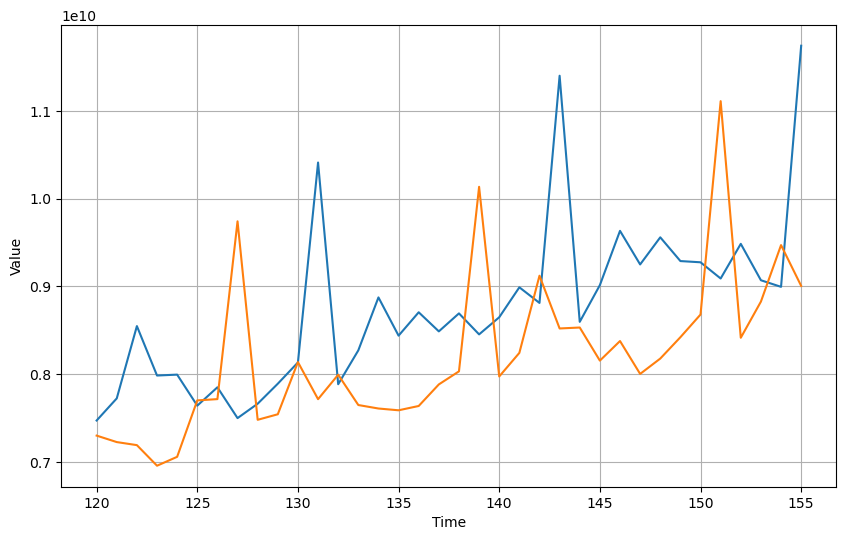

In [30]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [31]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(1),
])


model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=1.0))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 32ms/step - loss: 102.3798
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 97.2821
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 89.7340
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 71.5549
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 31.4888
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 81.4776
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 47.4500
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 60.9846
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 82.4738
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 77.9669
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 56.5755
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 33.9626
Epoch 13/500
4/4 [============================

4/4 [==============================] - 0s 5ms/step - loss: 43.1452
Epoch 205/500
4/4 [==============================] - 0s 4ms/step - loss: 25.1105
Epoch 206/500
4/4 [==============================] - 0s 4ms/step - loss: 42.8248
Epoch 207/500
4/4 [==============================] - 0s 4ms/step - loss: 28.7180
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 39.2875
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 48.7781
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 29.8387
Epoch 211/500
4/4 [==============================] - 0s 5ms/step - loss: 40.3547
Epoch 212/500
4/4 [==============================] - 0s 5ms/step - loss: 38.4920
Epoch 213/500
4/4 [==============================] - 0s 5ms/step - loss: 33.8546
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 52.8220
Epoch 215/500
4/4 [==============================] - 0s 6ms/step - loss: 43.1311
Epoch 216/500
4/4 [=======================

4/4 [==============================] - 0s 4ms/step - loss: 28.2853
Epoch 407/500
4/4 [==============================] - 0s 5ms/step - loss: 29.8656
Epoch 408/500
4/4 [==============================] - 0s 6ms/step - loss: 25.2200
Epoch 409/500
4/4 [==============================] - 0s 6ms/step - loss: 33.5285
Epoch 410/500
4/4 [==============================] - 0s 4ms/step - loss: 27.1109
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 33.4534
Epoch 412/500
4/4 [==============================] - 0s 5ms/step - loss: 27.2807
Epoch 413/500
4/4 [==============================] - 0s 5ms/step - loss: 28.3261
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 28.3007
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 27.2050
Epoch 416/500
4/4 [==============================] - 0s 4ms/step - loss: 28.8389
Epoch 417/500
4/4 [==============================] - 0s 4ms/step - loss: 26.6448
Epoch 418/500
4/4 [=======================

1/1 [==============================] - 0s 24ms/step


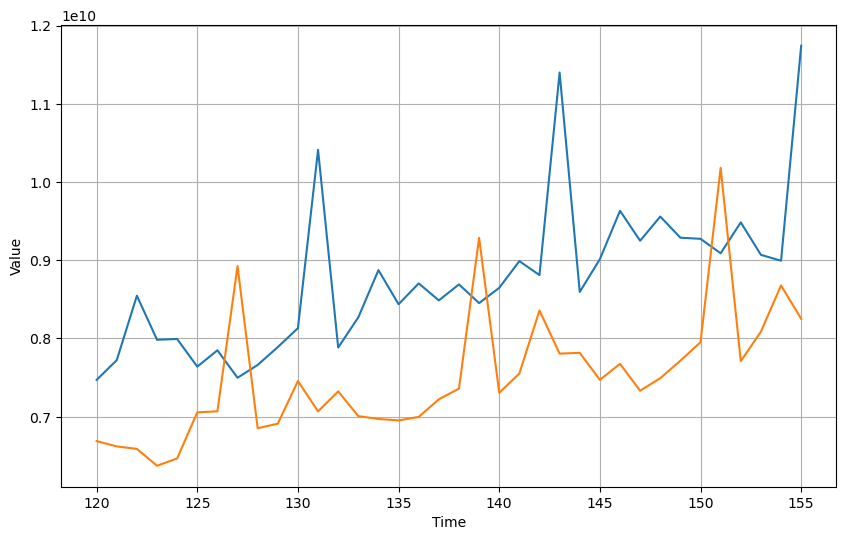

In [32]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [42]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding='causal', activation='relu', input_shape=[None, 1]))
  
  model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(momentum=0.5, lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

Trial 19 Complete [00h 00m 19s]
loss: 28.026503880818684

Best loss So Far: 26.15520731608073
Total elapsed time: 00h 05m 19s
INFO:tensorflow:Oracle triggered exit
CPU times: user 5min 59s, sys: 45.7 s, total: 6min 45s
Wall time: 5min 19s


In [43]:
tuner.results_summary()

Results summary
Results in my_dir/cnn-tune
Showing 10 best trials
Trial summary
Hyperparameters:
units: 128
kernels: 3
strides: 1
Score: 26.15520731608073
Trial summary
Hyperparameters:
units: 256
kernels: 3
strides: 2
Score: 26.211905161539715
Trial summary
Hyperparameters:
units: 128
kernels: 3
strides: 2
Score: 27.559672673543293
Trial summary
Hyperparameters:
units: 192
kernels: 3
strides: 3
Score: 27.950899759928387
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 1
Score: 28.026503880818684
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 1
Score: 28.265612920125324
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 2
Score: 29.06617546081543
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 2
Score: 29.076205571492512
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 2
Score: 29.19099299112956
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
Score: 30.230491638183594


In [46]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 29ms/step - loss: 87.8480
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 86.8843
Epoch 3/500
4/4 [==============================] - 0s 7ms/step - loss: 85.7815
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 84.6797
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 83.5734
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 82.5030
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 81.4364
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 80.3517
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 79.2382
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 78.1745
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 76.9737
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 75.8083
Epoch 13/500
4/4 [==============================

4/4 [==============================] - 0s 4ms/step - loss: 24.9448
Epoch 205/500
4/4 [==============================] - 0s 4ms/step - loss: 24.0321
Epoch 206/500
4/4 [==============================] - 0s 5ms/step - loss: 25.0906
Epoch 207/500
4/4 [==============================] - 0s 4ms/step - loss: 25.0078
Epoch 208/500
4/4 [==============================] - 0s 7ms/step - loss: 24.5971
Epoch 209/500
4/4 [==============================] - 0s 6ms/step - loss: 24.8455
Epoch 210/500
4/4 [==============================] - 0s 5ms/step - loss: 24.1306
Epoch 211/500
4/4 [==============================] - 0s 15ms/step - loss: 24.9476
Epoch 212/500
4/4 [==============================] - 0s 6ms/step - loss: 24.4312
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 24.8318
Epoch 214/500
4/4 [==============================] - 0s 6ms/step - loss: 24.9061
Epoch 215/500
4/4 [==============================] - 0s 7ms/step - loss: 24.9174
Epoch 216/500
4/4 [======================

4/4 [==============================] - 0s 4ms/step - loss: 24.2969
Epoch 407/500
4/4 [==============================] - 0s 3ms/step - loss: 24.3315
Epoch 408/500
4/4 [==============================] - 0s 3ms/step - loss: 24.2903
Epoch 409/500
4/4 [==============================] - 0s 3ms/step - loss: 23.6927
Epoch 410/500
4/4 [==============================] - 0s 3ms/step - loss: 23.7519
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 24.0392
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 24.3504
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 24.2563
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 23.1618
Epoch 415/500
4/4 [==============================] - 0s 3ms/step - loss: 24.1179
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 23.5753
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 24.3049
Epoch 418/500
4/4 [=======================

1/1 [==============================] - 0s 21ms/step


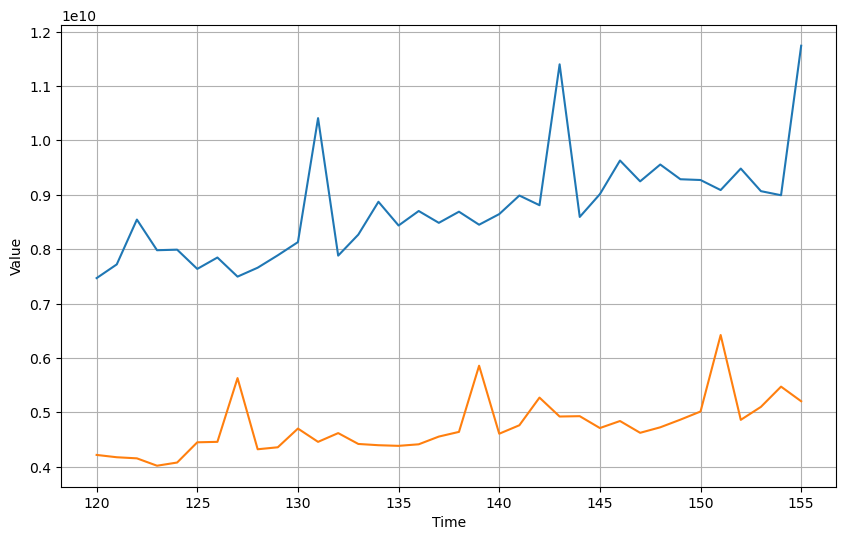

In [47]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [48]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding='causal', activation='relu', input_shape=[None, 1]))
  
  model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(momentum=1.0, lr=1e-4))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=2)

Trial 3 Complete [00h 01m 21s]
loss: 23.28050931294759

Best loss So Far: 23.28050931294759
Total elapsed time: 00h 04m 04s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
192               |192               |units
6                 |9                 |kernels
3                 |2                 |strides

Epoch 1/500
4/4 - 1s - loss: 108.0334 - 800ms/epoch - 200ms/step
Epoch 2/500
4/4 - 0s - loss: 97.9894 - 101ms/epoch - 25ms/step
Epoch 3/500
4/4 - 0s - loss: 93.3016 - 76ms/epoch - 19ms/step
Epoch 4/500
4/4 - 0s - loss: 81.7348 - 69ms/epoch - 17ms/step
Epoch 5/500
4/4 - 0s - loss: 44.2600 - 53ms/epoch - 13ms/step
Epoch 6/500
4/4 - 0s - loss: 77.8510 - 48ms/epoch - 12ms/step
Epoch 7/500
4/4 - 0s - loss: 64.0669 - 44ms/epoch - 11ms/step
Epoch 8/500
4/4 - 0s - loss: 51.9526 - 33ms/epoch - 8ms/step
Epoch 9/500
4/4 - 0s - loss: 82.5042 - 37ms/epoch - 9ms/step
Epoch 10/500
4/4 - 0s - loss: 89.2636 - 36ms/epoch - 9ms/step
Epoch 11/500
4/4 - 0s - loss: 87.1171

Epoch 127/500
4/4 - 0s - loss: 24.7372 - 31ms/epoch - 8ms/step
Epoch 128/500
4/4 - 0s - loss: 34.3082 - 34ms/epoch - 8ms/step
Epoch 129/500
4/4 - 0s - loss: 25.6423 - 33ms/epoch - 8ms/step
Epoch 130/500
4/4 - 0s - loss: 32.9669 - 34ms/epoch - 9ms/step
Epoch 131/500
4/4 - 0s - loss: 25.2797 - 35ms/epoch - 9ms/step
Epoch 132/500
4/4 - 0s - loss: 30.5452 - 33ms/epoch - 8ms/step
Epoch 133/500
4/4 - 0s - loss: 24.8598 - 34ms/epoch - 9ms/step
Epoch 134/500
4/4 - 0s - loss: 25.0981 - 32ms/epoch - 8ms/step
Epoch 135/500
4/4 - 0s - loss: 25.5990 - 34ms/epoch - 8ms/step
Epoch 136/500
4/4 - 0s - loss: 24.5695 - 35ms/epoch - 9ms/step
Epoch 137/500
4/4 - 0s - loss: 25.9741 - 32ms/epoch - 8ms/step
Epoch 138/500
4/4 - 0s - loss: 24.9480 - 33ms/epoch - 8ms/step
Epoch 139/500
4/4 - 0s - loss: 25.7949 - 35ms/epoch - 9ms/step
Epoch 140/500
4/4 - 0s - loss: 24.2435 - 45ms/epoch - 11ms/step
Epoch 141/500
4/4 - 0s - loss: 26.7080 - 50ms/epoch - 13ms/step
Epoch 142/500
4/4 - 0s - loss: 23.8776 - 37ms/epoch -

4/4 - 0s - loss: 34.6510 - 28ms/epoch - 7ms/step
Epoch 257/500
4/4 - 0s - loss: 30.9153 - 29ms/epoch - 7ms/step
Epoch 258/500
4/4 - 0s - loss: 27.9063 - 29ms/epoch - 7ms/step
Epoch 259/500
4/4 - 0s - loss: 28.9449 - 29ms/epoch - 7ms/step
Epoch 260/500
4/4 - 0s - loss: 34.8796 - 29ms/epoch - 7ms/step
Epoch 261/500
4/4 - 0s - loss: 49.0849 - 30ms/epoch - 7ms/step
Epoch 262/500
4/4 - 0s - loss: 49.2661 - 28ms/epoch - 7ms/step
Epoch 263/500
4/4 - 0s - loss: 90.3719 - 30ms/epoch - 8ms/step
Epoch 264/500
4/4 - 0s - loss: 100.0000 - 28ms/epoch - 7ms/step
Epoch 265/500
4/4 - 0s - loss: 100.0000 - 29ms/epoch - 7ms/step
Epoch 266/500
4/4 - 0s - loss: 100.0000 - 30ms/epoch - 8ms/step
Epoch 267/500
4/4 - 0s - loss: 100.0000 - 30ms/epoch - 7ms/step
Epoch 268/500
4/4 - 0s - loss: 100.0000 - 32ms/epoch - 8ms/step
Epoch 269/500
4/4 - 0s - loss: 100.0000 - 31ms/epoch - 8ms/step
Epoch 270/500
4/4 - 0s - loss: 100.0000 - 29ms/epoch - 7ms/step
Epoch 271/500
4/4 - 0s - loss: 100.0000 - 28ms/epoch - 7ms/ste

4/4 - 0s - loss: 100.0000 - 31ms/epoch - 8ms/step
Epoch 385/500
4/4 - 0s - loss: 100.0000 - 30ms/epoch - 7ms/step
Epoch 386/500
4/4 - 0s - loss: 100.0000 - 30ms/epoch - 8ms/step
Epoch 387/500
4/4 - 0s - loss: 100.0000 - 29ms/epoch - 7ms/step
Epoch 388/500
4/4 - 0s - loss: 100.0000 - 30ms/epoch - 8ms/step
Epoch 389/500
4/4 - 0s - loss: 100.0000 - 30ms/epoch - 7ms/step
Epoch 390/500
4/4 - 0s - loss: 100.0000 - 30ms/epoch - 7ms/step
Epoch 391/500
4/4 - 0s - loss: 100.0000 - 31ms/epoch - 8ms/step
Epoch 392/500
4/4 - 0s - loss: 100.0000 - 36ms/epoch - 9ms/step
Epoch 393/500
4/4 - 0s - loss: 100.0000 - 42ms/epoch - 10ms/step
Epoch 394/500
4/4 - 0s - loss: 100.0000 - 34ms/epoch - 9ms/step
Epoch 395/500
4/4 - 0s - loss: 100.0000 - 41ms/epoch - 10ms/step
Epoch 396/500
4/4 - 0s - loss: 100.0000 - 38ms/epoch - 10ms/step
Epoch 397/500
4/4 - 0s - loss: 100.0000 - 33ms/epoch - 8ms/step
Epoch 398/500
4/4 - 0s - loss: 100.0000 - 35ms/epoch - 9ms/step
Epoch 399/500
4/4 - 0s - loss: 100.0000 - 35ms/epoc

Epoch 13/500
4/4 - 0s - loss: 33.9369 - 30ms/epoch - 8ms/step
Epoch 14/500
4/4 - 0s - loss: 64.4512 - 30ms/epoch - 7ms/step
Epoch 15/500
4/4 - 0s - loss: 76.3475 - 32ms/epoch - 8ms/step
Epoch 16/500
4/4 - 0s - loss: 66.8915 - 29ms/epoch - 7ms/step
Epoch 17/500
4/4 - 0s - loss: 32.4550 - 30ms/epoch - 8ms/step
Epoch 18/500
4/4 - 0s - loss: 70.7010 - 116ms/epoch - 29ms/step
Epoch 19/500
4/4 - 0s - loss: 30.5061 - 44ms/epoch - 11ms/step
Epoch 20/500
4/4 - 0s - loss: 64.0551 - 37ms/epoch - 9ms/step
Epoch 21/500
4/4 - 0s - loss: 73.9499 - 30ms/epoch - 8ms/step
Epoch 22/500
4/4 - 0s - loss: 57.3226 - 29ms/epoch - 7ms/step
Epoch 23/500
4/4 - 0s - loss: 31.6913 - 30ms/epoch - 8ms/step
Epoch 24/500
4/4 - 0s - loss: 61.4283 - 29ms/epoch - 7ms/step
Epoch 25/500
4/4 - 0s - loss: 34.1158 - 29ms/epoch - 7ms/step
Epoch 26/500
4/4 - 0s - loss: 65.5369 - 29ms/epoch - 7ms/step
Epoch 27/500
4/4 - 0s - loss: 58.9148 - 29ms/epoch - 7ms/step
Epoch 28/500
4/4 - 0s - loss: 28.9263 - 30ms/epoch - 7ms/step
Epoch

Epoch 144/500
4/4 - 0s - loss: 28.5424 - 47ms/epoch - 12ms/step
Epoch 145/500
4/4 - 0s - loss: 30.6100 - 58ms/epoch - 15ms/step
Epoch 146/500
4/4 - 0s - loss: 25.5159 - 94ms/epoch - 23ms/step
Epoch 147/500
4/4 - 0s - loss: 29.0158 - 49ms/epoch - 12ms/step
Epoch 148/500
4/4 - 0s - loss: 28.2799 - 54ms/epoch - 14ms/step
Epoch 149/500
4/4 - 0s - loss: 26.7061 - 67ms/epoch - 17ms/step
Epoch 150/500
4/4 - 0s - loss: 28.3702 - 32ms/epoch - 8ms/step
Epoch 151/500
4/4 - 0s - loss: 26.5314 - 33ms/epoch - 8ms/step
Epoch 152/500
4/4 - 0s - loss: 32.1108 - 30ms/epoch - 8ms/step
Epoch 153/500
4/4 - 0s - loss: 25.6970 - 30ms/epoch - 8ms/step
Epoch 154/500
4/4 - 0s - loss: 28.7237 - 29ms/epoch - 7ms/step
Epoch 155/500
4/4 - 0s - loss: 26.5747 - 30ms/epoch - 7ms/step
Epoch 156/500
4/4 - 0s - loss: 26.5014 - 33ms/epoch - 8ms/step
Epoch 157/500
4/4 - 0s - loss: 29.8173 - 33ms/epoch - 8ms/step
Epoch 158/500
4/4 - 0s - loss: 25.7284 - 35ms/epoch - 9ms/step
Epoch 159/500
4/4 - 0s - loss: 34.2879 - 35ms/epo

Epoch 274/500
4/4 - 0s - loss: 26.3451 - 33ms/epoch - 8ms/step
Epoch 275/500
4/4 - 0s - loss: 25.7521 - 38ms/epoch - 9ms/step
Epoch 276/500
4/4 - 0s - loss: 29.3846 - 30ms/epoch - 7ms/step
Epoch 277/500
4/4 - 0s - loss: 24.9896 - 30ms/epoch - 7ms/step
Epoch 278/500
4/4 - 0s - loss: 23.5621 - 30ms/epoch - 8ms/step
Epoch 279/500
4/4 - 0s - loss: 24.4310 - 30ms/epoch - 8ms/step
Epoch 280/500
4/4 - 0s - loss: 24.5683 - 30ms/epoch - 8ms/step
Epoch 281/500
4/4 - 0s - loss: 23.4377 - 35ms/epoch - 9ms/step
Epoch 282/500
4/4 - 0s - loss: 23.8130 - 31ms/epoch - 8ms/step
Epoch 283/500
4/4 - 0s - loss: 24.0274 - 46ms/epoch - 11ms/step
Epoch 284/500
4/4 - 0s - loss: 23.4283 - 33ms/epoch - 8ms/step
Epoch 285/500
4/4 - 0s - loss: 27.8134 - 30ms/epoch - 7ms/step
Epoch 286/500
4/4 - 0s - loss: 26.0139 - 35ms/epoch - 9ms/step
Epoch 287/500
4/4 - 0s - loss: 25.8492 - 43ms/epoch - 11ms/step
Epoch 288/500
4/4 - 0s - loss: 24.6429 - 41ms/epoch - 10ms/step
Epoch 289/500
4/4 - 0s - loss: 23.6091 - 41ms/epoch 

KeyboardInterrupt: 

In [50]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding='causal', activation='relu', input_shape=[None, 1]))
  
  model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(momentum=0.5, lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=2)

Trial 20 Complete [00h 01m 20s]
loss: 23.296560287475586

Best loss So Far: 22.698318481445312
Total elapsed time: 00h 24m 10s
INFO:tensorflow:Oracle triggered exit
CPU times: user 27min 36s, sys: 3min 47s, total: 31min 24s
Wall time: 24min 10s


In [51]:
tuner.results_summary()

Results summary
Results in my_dir/cnn-tune
Showing 10 best trials
Trial summary
Hyperparameters:
units: 128
kernels: 3
strides: 3
Score: 22.698318481445312
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 3
Score: 22.769973754882812
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 3
Score: 22.812297185262043
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
Score: 22.858277638753254
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 1
Score: 22.890984853108723
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 2
Score: 22.931601842244465
Trial summary
Hyperparameters:
units: 128
kernels: 3
strides: 2
Score: 23.001664479573567
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 1
Score: 23.00345230102539
Trial summary
Hyperparameters:
units: 192
kernels: 3
strides: 1
Score: 23.108600616455078
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 1
Score: 23.26075045267741


In [52]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=3, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 33ms/step - loss: 99.8896
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 96.5004
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 93.1287
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 89.8672
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 86.7570
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 83.6801
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 80.5714
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 77.4873
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 75.1727
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 73.0086
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 70.8511
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 68.5851
Epoch 13/500
4/4 [=============================

4/4 [==============================] - 0s 4ms/step - loss: 26.9490
Epoch 205/500
4/4 [==============================] - 0s 4ms/step - loss: 27.1374
Epoch 206/500
4/4 [==============================] - 0s 4ms/step - loss: 26.8169
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 26.4085
Epoch 208/500
4/4 [==============================] - 0s 3ms/step - loss: 26.5932
Epoch 209/500
4/4 [==============================] - 0s 3ms/step - loss: 26.8362
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 27.1514
Epoch 211/500
4/4 [==============================] - 0s 5ms/step - loss: 26.8429
Epoch 212/500
4/4 [==============================] - 0s 4ms/step - loss: 26.9218
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 26.5849
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 27.0349
Epoch 215/500
4/4 [==============================] - 0s 4ms/step - loss: 27.0395
Epoch 216/500
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 22.7828
Epoch 407/500
4/4 [==============================] - 0s 5ms/step - loss: 24.2179
Epoch 408/500
4/4 [==============================] - 0s 4ms/step - loss: 23.8699
Epoch 409/500
4/4 [==============================] - 0s 4ms/step - loss: 24.1567
Epoch 410/500
4/4 [==============================] - 0s 4ms/step - loss: 24.3488
Epoch 411/500
4/4 [==============================] - 0s 5ms/step - loss: 24.0147
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 23.6853
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 24.1686
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 24.1389
Epoch 415/500
4/4 [==============================] - 0s 3ms/step - loss: 23.6607
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 24.1228
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 24.1688
Epoch 418/500
4/4 [=======================

1/1 [==============================] - 0s 24ms/step


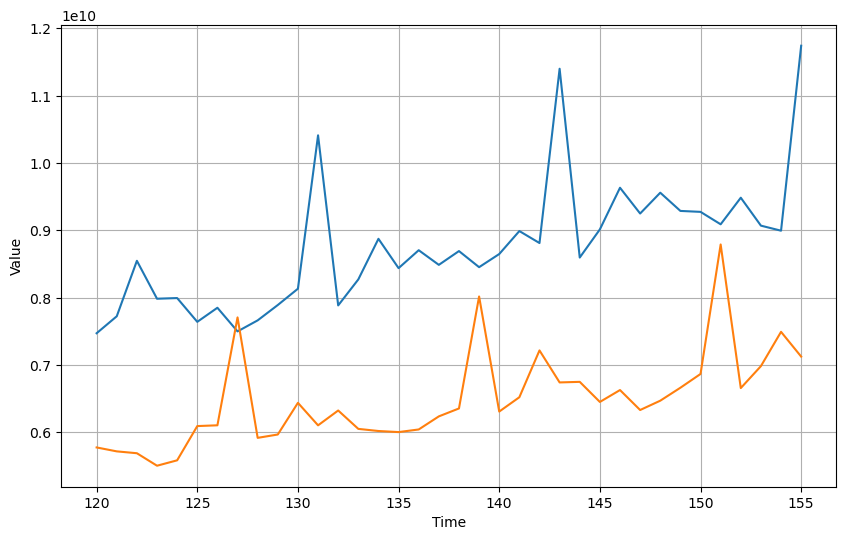

In [53]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [54]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.25556890864813453


In [63]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding='causal', input_shape=[None, 1]))
  
  model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(momentum=0.5, lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='CNN_1')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=2)

Trial 20 Complete [00h 00m 47s]
loss: 23.813358306884766

Best loss So Far: 22.561920166015625
Total elapsed time: 00h 19m 57s
INFO:tensorflow:Oracle triggered exit
CPU times: user 21min 16s, sys: 3min 1s, total: 24min 17s
Wall time: 19min 57s


In [64]:
tuner.results_summary()

Results summary
Results in my_dir/CNN_1
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 2
Score: 22.561920166015625
Trial summary
Hyperparameters:
units: 192
kernels: 3
strides: 3
Score: 22.644203821818035
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
Score: 22.706748326619465
Trial summary
Hyperparameters:
units: 256
kernels: 3
strides: 3
Score: 22.731516520182293
Trial summary
Hyperparameters:
units: 128
kernels: 3
strides: 3
Score: 22.83924166361491
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 1
Score: 22.93282953898112
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 1
Score: 23.05360158284505
Trial summary
Hyperparameters:
units: 192
kernels: 3
strides: 2
Score: 23.13201840718587
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 1
Score: 23.253747940063477
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 1
Score: 23.471028010050457


In [72]:
%%time
# units：192・kernels：6・strindes：2
# ReLU・エポック数500
# my_dir/CNN_2

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding='causal', activation='relu', input_shape=[None, 1]))

  model.add(Dense(units=hp.Int('units1', min_value=2, max_value=30, step=4), input_shape=[window_size], activation='relu'))
  model.add(Dense(units=hp.Int('units2', min_value=2, max_value=30, step=4), activation='relu'))
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9]), lr=1e-4))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=60, executions_per_trial=3, directory='my_dir', project_name='CNN_2')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=2)

Trial 60 Complete [00h 01m 01s]
loss: 21.379817326863606

Best loss So Far: 20.736125946044922
Total elapsed time: 01h 32m 51s
INFO:tensorflow:Oracle triggered exit
CPU times: user 1h 13min 9s, sys: 9min 53s, total: 1h 23min 2s
Wall time: 1h 32min 50s


In [73]:
tuner.results_summary()

Results summary
Results in my_dir/CNN_2
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 3
units1: 6
units2: 14
momentum: 0.9
Score: 20.736125946044922
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 2
units1: 6
units2: 18
momentum: 0.9
Score: 20.83147939046224
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 3
units1: 18
units2: 18
momentum: 0.7
Score: 20.846240361531574
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 2
units1: 2
units2: 10
momentum: 0.5
Score: 20.916470845540363
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 2
units1: 26
units2: 22
momentum: 0.5
Score: 20.953372955322266
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 2
units1: 14
units2: 18
momentum: 0.7
Score: 20.960975011189777
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
units1: 18
units2: 10
momentum: 0.7
Score: 21.049849192301433
Trial summary
Hyperparameters:
units: 128
kernels: 6
stride

In [77]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=192, kernel_size=9,
                      strides=3, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(6, activation="relu"), 
    tf.keras.layers.Dense(14, activation="relu"), 
    tf.keras.layers.Dense(1),
])


model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 9ms/step - loss: 102.1089
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 99.5057
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 97.5154
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 95.2342
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 90.8394
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 83.1041
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 65.6844
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 40.4925
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 48.7524
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 37.9425
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 39.2886
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 35.8132
Epoch 13/500
4/4 [==============================] - 0s 3ms/s

4/4 [==============================] - 0s 2ms/step - loss: 21.9747
Epoch 205/500
4/4 [==============================] - 0s 2ms/step - loss: 22.5822
Epoch 206/500
4/4 [==============================] - 0s 2ms/step - loss: 21.5119
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 22.4938
Epoch 208/500
4/4 [==============================] - 0s 3ms/step - loss: 22.0031
Epoch 209/500
4/4 [==============================] - 0s 2ms/step - loss: 22.1226
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 22.1849
Epoch 211/500
4/4 [==============================] - 0s 2ms/step - loss: 22.1936
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 22.3540
Epoch 213/500
4/4 [==============================] - 0s 3ms/step - loss: 21.9372
Epoch 214/500
4/4 [==============================] - 0s 2ms/step - loss: 21.9834
Epoch 215/500
4/4 [==============================] - 0s 2ms/step - loss: 22.3641
Epoch 216/500
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 22.2176
Epoch 407/500
4/4 [==============================] - 0s 3ms/step - loss: 21.9020
Epoch 408/500
4/4 [==============================] - 0s 2ms/step - loss: 21.1214
Epoch 409/500
4/4 [==============================] - 0s 3ms/step - loss: 21.8164
Epoch 410/500
4/4 [==============================] - 0s 3ms/step - loss: 21.8434
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 22.2381
Epoch 412/500
4/4 [==============================] - 0s 5ms/step - loss: 22.2197
Epoch 413/500
4/4 [==============================] - 0s 2ms/step - loss: 22.2708
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 21.5713
Epoch 415/500
4/4 [==============================] - 0s 5ms/step - loss: 22.4095
Epoch 416/500
4/4 [==============================] - 0s 5ms/step - loss: 22.3928
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 21.9103
Epoch 418/500
4/4 [=======================

1/1 [==============================] - 0s 16ms/step


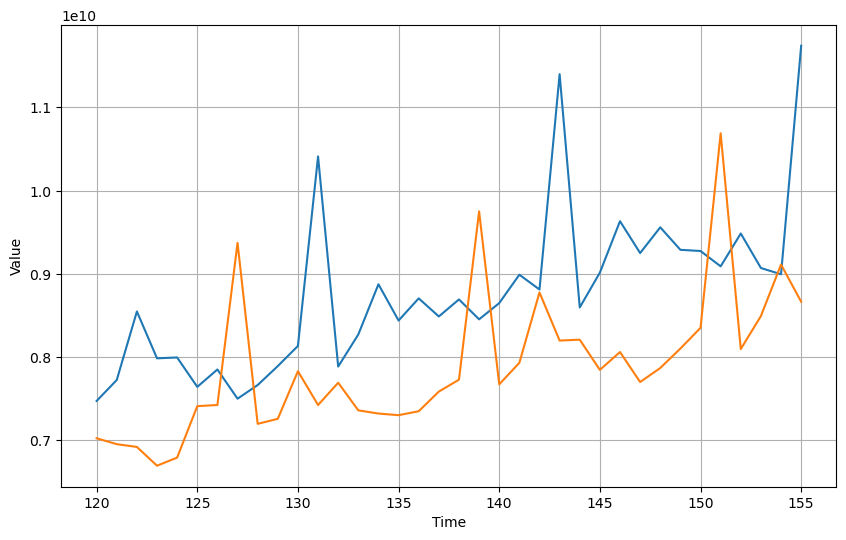

In [78]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [79]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.12565999601331065
